In [ ]:
!kaggle datasets download jehanbhathena/weather-dataset
!unzip weather-dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: dataset/frost/3913.jpg  
  inflating: dataset/frost/3914.jpg  
  inflating: dataset/frost/3915.jpg  
  inflating: dataset/frost/3916.jpg  
  inflating: dataset/frost/3917.jpg  
  inflating: dataset/frost/3918.jpg  
  inflating: dataset/frost/3919.jpg  
  inflating: dataset/frost/3920.jpg  
  inflating: dataset/frost/3921.jpg  
  inflating: dataset/frost/3922.jpg  
  inflating: dataset/frost/3923.jpg  
  inflating: dataset/frost/3924.jpg  
  inflating: dataset/frost/3925.jpg  
  inflating: dataset/frost/3926.jpg  
  inflating: dataset/frost/3927.jpg  
  inflating: dataset/frost/3928.jpg  
  inflating: dataset/frost/3929.jpg  
  inflating: dataset/frost/3930.jpg  
  inflating: dataset/frost/3931.jpg  
  inflating: dataset/frost/3932.jpg  
  inflating: dataset/frost/3933.jpg  
  inflating: dataset/frost/3934.jpg  
  inflating: dataset/frost/3935.jpg  
  inflating: dataset/frost/3936.jpg  
  inflating: dataset/frost/3937.jpg  

## Análisis Exploratorio de Datos (EDA)

In [ ]:
import os
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from collections import Counter

In [ ]:
# Directorio del Dataset
data_dir = 'dataset'

In [ ]:
# Listar las carpetas (clases)
classes = os.listdir(data_dir)
print(f"Clases encontradas: {classes}")

Clases encontradas: ['rain', 'fogsmog', 'rime', 'frost', 'sandstorm', 'snow', 'dew', 'lightning', 'hail', 'rainbow', 'glaze']


In [ ]:
# Contar el número de imágenes por clase
image_count = {
    cls: len(os.listdir(os.path.join(data_dir, cls)))
    for cls in classes
}
print(f"Imágenes por clase: {image_count}")

Imágenes por clase: {'rain': 526, 'fogsmog': 851, 'rime': 1160, 'frost': 475, 'sandstorm': 692, 'snow': 621, 'dew': 698, 'lightning': 377, 'hail': 591, 'rainbow': 232, 'glaze': 639}


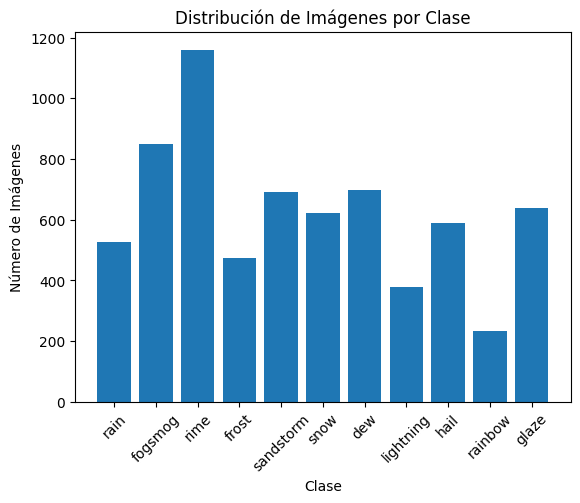

In [ ]:
# Visualizar distribución de imágenes por clase
plt.bar(image_count.keys(), image_count.values())
plt.title('Distribución de Imágenes por Clase')
plt.xlabel('Clase')
plt.ylabel('Número de Imágenes')
plt.xticks(rotation=45)
plt.show()

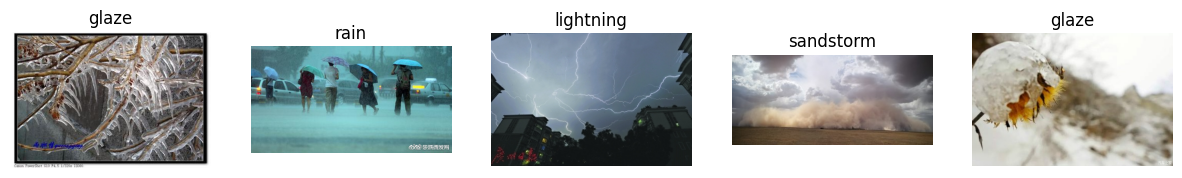

In [ ]:
# Mostrar imágenes al azar
def show_random_images(data_dir, classes, num_images=5):
  fig, axes = plt.subplots(1, num_images, figsize=(15, 15))

  for ax in axes:
    cls = np.random.choice(classes)
    img_path = os.path.join(data_dir, cls, np.random.choice(os.listdir(os.path.join(data_dir, cls))))
    img = Image.open(img_path)
    ax.imshow(img)
    ax.set_title(cls)
    ax.axis('off')

  plt.show()

show_random_images(data_dir, classes)

## Separar las imágenes en 3 conjuntos para el modelo

In [ ]:
import shutil
from sklearn.model_selection import train_test_split

In [ ]:
# Establecer porcentajes para los conjuntos
validation_split = 0.15
test_split = 0.15
train_split = 1 - validation_split - test_split

# Configuración de directorios
train_dir = os.path.join(data_dir, 'train')
valid_dir = os.path.join(data_dir, 'valid')
test_dir = os.path.join(data_dir, 'test')

# Crear directorios de salida
os.makedirs(train_dir, exist_ok=True)
os.makedirs(valid_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

In [ ]:
# Procesar cada clase
for cls in classes:
    cls_dir = os.path.join(data_dir, cls)

    # Ignorar carpetas que no sean clases
    if not os.path.isdir(cls_dir):
        continue

    # Obtener imágenes de la clase
    images = os.listdir(cls_dir)

    # Separar en entrenamiento, validación y prueba
    try:
      train_images, temp_images = train_test_split(images, test_size=(validation_split + test_split), random_state=42)
      valid_images, test_images = train_test_split(temp_images, test_size=(test_split / (validation_split + test_split)), random_state=42)
    except ValueError as e:
      print(f"Error al dividir las imágenes de la clase '{cls}': {e}")
      continue

    # Crear subcarpetas para la clase en cada conjunto
    os.makedirs(os.path.join(train_dir, cls), exist_ok=True)
    os.makedirs(os.path.join(valid_dir, cls), exist_ok=True)
    os.makedirs(os.path.join(test_dir, cls), exist_ok=True)

    # Mover imágenes a los conjuntos correspondientes
    for image in train_images:
        shutil.move(os.path.join(cls_dir, image), os.path.join(train_dir, cls, image))

    for image in valid_images:
        shutil.move(os.path.join(cls_dir, image), os.path.join(valid_dir, cls, image))

    for image in test_images:
        shutil.move(os.path.join(cls_dir, image), os.path.join(test_dir, cls, image))

print("Conjuntos creados con éxito:")
print(f"- Entrenamiento: {train_dir}")
print(f"- Validación: {valid_dir}")
print(f"- Prueba: {test_dir}")

Conjuntos creados con éxito:
- Entrenamiento: dataset/train
- Validación: dataset/valid
- Prueba: dataset/test


In [ ]:
# Verificar las cantidades en cada conjunto
def count_images_in_directory(directory):
    total = 0
    for cls in os.listdir(directory):
        total += len(os.listdir(os.path.join(directory, cls)))
    return total

print(f"Imágenes en entrenamiento: {count_images_in_directory(train_dir)}")
print(f"Imágenes en validación: {count_images_in_directory(valid_dir)}")
print(f"Imágenes en prueba: {count_images_in_directory(test_dir)}")


Imágenes en entrenamiento: 4798
Imágenes en validación: 1031
Imágenes en prueba: 1033


In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
# Preprocesamiento
data_gen = ImageDataGenerator(
    rescale=1./255,           # Normalización
    rotation_range=30,        # Aumento: rotaciones
    width_shift_range=0.2,    # Desplazamientos horizontales
    height_shift_range=0.2,   # Desplazamientos verticales
    zoom_range=0.2,           # Zoom aleatorio
    horizontal_flip=True,     # Volteo horizontal
    #validation_split=0.15     # Separación de validación
)

In [ ]:
# Crear generadores de datos
train_gen = data_gen.flow_from_directory(
    train_dir,
    target_size=(64, 64),
    batch_size=32,
    class_mode='categorical'
)

Found 4798 images belonging to 11 classes.


In [ ]:
# Generadores de validación y prueba (sin aumento)
valid_gen = ImageDataGenerator(rescale=1./255).flow_from_directory(
    valid_dir,
    target_size=(64, 64),
    batch_size=32,
    class_mode='categorical'
)

test_gen = ImageDataGenerator(rescale=1./255).flow_from_directory(
    test_dir,
    target_size=(64, 64),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

Found 1031 images belonging to 11 classes.
Found 1033 images belonging to 11 classes.


## Diseño del modelo

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization

In [ ]:
# Crear el modelo
model = Sequential([
    # Primera capa convolucional + pooling
    Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    # Segunda capa convolucional + pooling
    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    # Tercera capa convolucional + pooling
    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    # Primera capa convolucional adicional
    Conv2D(256, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    # Aplanar y añadir capas densas
    Flatten(),

    # Primera capa densa
    Dense(256, activation='relu'),
    Dropout(0.5),  # Regularización para evitar sobreajuste

    # Segunda capa densa
    Dense(128, activation='relu'),
    Dropout(0.5),  # Regularización para evitar sobreajuste

    # Capa de salida
    Dense(len(classes), activation='softmax')
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
# Compilar el modelo
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 62, 62, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 62, 62, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 31, 31, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 29, 29, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 29, 29, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 12, 12, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 12, 12, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 6, 6, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 4, 4, 256)           │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 4, 4, 256)           │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 2, 2, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │         262,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 11)                  │           1,419 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 687,051 (2.62 MB)

 Trainable params: 686,091 (2.62 MB)

 Non-trainable params: 960 (3.75 KB)

## Entrenamiento del modelo

In [ ]:
history = model.fit(
    train_gen,
    validation_data=valid_gen,
    epochs=15,
    steps_per_epoch=train_gen.samples // train_gen.batch_size,
    validation_steps=valid_gen.samples // valid_gen.batch_size
)

Epoch 1/15


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


149/149 ━━━━━━━━━━━━━━━━━━━━ 77s 482ms/step - accuracy: 0.3033 - loss: 2.6031 - val_accuracy: 0.1250 - val_loss: 3.9639
Epoch 2/15
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 432us/step - accuracy: 0.6562 - loss: 1.3993 - val_accuracy: 0.2857 - val_loss: 2.2627
Epoch 3/15


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


149/149 ━━━━━━━━━━━━━━━━━━━━ 82s 488ms/step - accuracy: 0.4379 - loss: 1.7067 - val_accuracy: 0.2480 - val_loss: 2.3305
Epoch 4/15
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 261us/step - accuracy: 0.3750 - loss: 1.7230 - val_accuracy: 0.2857 - val_loss: 2.3401
Epoch 5/15
149/149 ━━━━━━━━━━━━━━━━━━━━ 80s 477ms/step - accuracy: 0.4889 - loss: 1.5444 - val_accuracy: 0.4121 - val_loss: 1.8410
Epoch 6/15
149/149 ━━━━━━━━━━━━━━━━━━━━ 1s 253us/step - accuracy: 0.5000 - loss: 1.5082 - val_accuracy: 0.5714 - val_loss: 1.8357
Epoch 7/15
149/149 ━━━━━━━━━━━━━━━━━━━━ 70s 461ms/step - accuracy: 0.5160 - loss: 1.4956 - val_accuracy: 0.4326 - val_loss: 1.4545
Epoch 8/15
149/149 ━━━━━━━━━━━━━━━━━━━━ 1s 420us/step - accuracy: 0.5000 - loss: 1.8243 - val_accuracy: 0.5714 - val_loss: 1.3234
Epoch 9/15
149/149 ━━━━━━━━━━━━━━━━━━━━ 71s 466ms/step - accuracy: 0.5310 - loss: 1.4055 - val_accuracy: 0.4697 - val_loss: 1.5409
Epoch 10/15
149/149 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - accuracy: 0.5938 - loss: 1.3565 - val_acc

## Evaluación del modelo

In [ ]:
# Evaluar el modelo con el conjunto de prueba
test_loss, test_accuracy = model.evaluate(test_gen, steps=test_gen.samples // test_gen.batch_size)

print(f"Precisión en el conjunto de prueba: {test_accuracy * 100:.2f}%")
print(f"Pérdida en el conjunto de prueba: {test_loss:.4f}")

32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 153ms/step - accuracy: 0.5671 - loss: 1.4382
Precisión en el conjunto de prueba: 51.46%
Pérdida en el conjunto de prueba: 1.5321


## Matriz de confusión

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

33/33 ━━━━━━━━━━━━━━━━━━━━ 7s 186ms/step


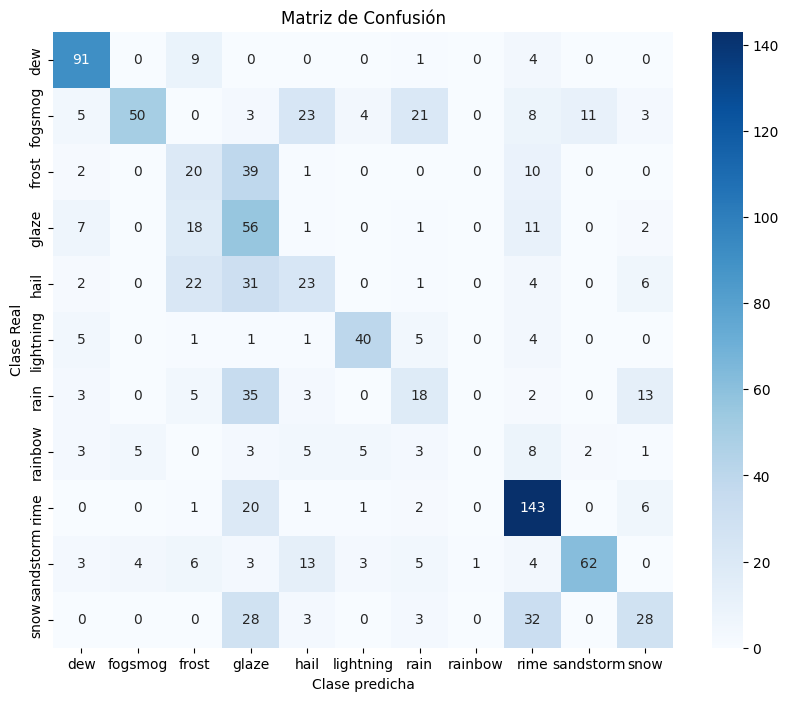


Reporte de Clasificación:
              precision    recall  f1-score   support

         dew       0.75      0.87      0.81       105
     fogsmog       0.85      0.39      0.53       128
       frost       0.24      0.28      0.26        72
       glaze       0.26      0.58      0.36        96
        hail       0.31      0.26      0.28        89
   lightning       0.75      0.70      0.73        57
        rain       0.30      0.23      0.26        79
     rainbow       0.00      0.00      0.00        35
        rime       0.62      0.82      0.71       174
   sandstorm       0.83      0.60      0.69       104
        snow       0.47      0.30      0.37        94

    accuracy                           0.51      1033
   macro avg       0.49      0.46      0.45      1033
weighted avg       0.54      0.51      0.51      1033



In [ ]:
# Obtener predicciones
test_gen.reset()
predictions = model.predict(test_gen, steps=len(test_gen), verbose=1)
predicted_classes = np.argmax(predictions, axis=1)

# Obtener etiquetas verdaderas
true_classes = test_gen.classes
class_labels = list(test_gen.class_indices.keys())

# Matriz de confusión
confusion_mtx = confusion_matrix(true_classes, predicted_classes)

# Visualizar matriz de confusión
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Matriz de Confusión')
plt.ylabel('Clase Real')
plt.xlabel('Clase predicha')
plt.show()

# Reporte de clasificación
print("\nReporte de Clasificación:")
print(classification_report(true_classes, predicted_classes, target_names=class_labels))

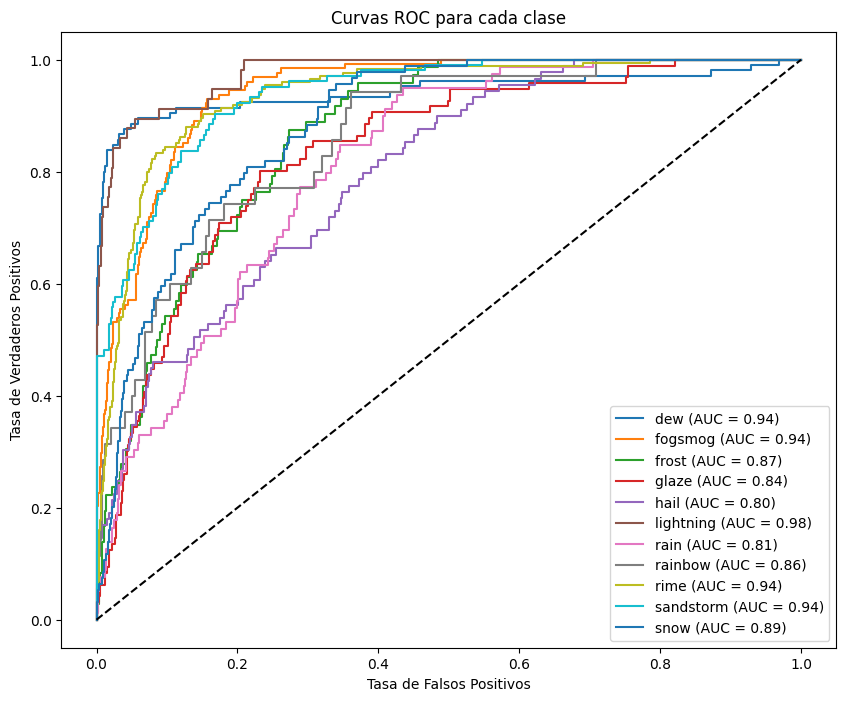

In [ ]:
# prompt: Make the ROC curv graphic for all classes

from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt

# Binarizar las etiquetas
y_true_bin = label_binarize(true_classes, classes=np.arange(len(class_labels)))

# Calcular las curvas ROC para cada clase
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(len(class_labels)):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], predictions[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Graficar las curvas ROC
plt.figure(figsize=(10, 8))
for i in range(len(class_labels)):
    plt.plot(fpr[i], tpr[i], label=f'{class_labels[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')  # Línea de referencia
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curvas ROC para cada clase')
plt.legend(loc='lower right')
plt.show()